In [1]:
import pandas as pd
import numpy as np
import cv2
from ast import literal_eval
from tqdm import tqdm
import os

import plotly_express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from matplotlib_venn import *

from plotly.offline import init_notebook_mode
init_notebook_mode()

In [2]:
BASE_DIR = "../input/ranzcr-clip-catheter-line-classification/"
df = pd.read_csv(BASE_DIR + 'train.csv')
df.head()

StudyInstanceUID  ETT - Abnormal  \
0  1.2.826.0.1.3680043.8.498.26697628953273228189...               0   
1  1.2.826.0.1.3680043.8.498.46302891597398758759...               0   
2  1.2.826.0.1.3680043.8.498.23819260719748494858...               0   
3  1.2.826.0.1.3680043.8.498.68286643202323212801...               0   
4  1.2.826.0.1.3680043.8.498.10050203009225938259...               0   

   ETT - Borderline  ETT - Normal  NGT - Abnormal  NGT - Borderline  \
0                 0             0               0                 0   
1                 0             1               0                 0   
2                 0             0               0                 0   
3                 0             0               0                 0   
4                 0             0               0                 0   

   NGT - Incompletely Imaged  NGT - Normal  CVC - Abnormal  CVC - Borderline  \
0                          0             1               0                 0   
1                          1             0               0                 0   
2                          0             0               0                 1   
3                          0             0               1                 0   
4                          0             0               0                 0   

   CVC - Normal  Swan Ganz Catheter Present  PatientID  
0             0                           0  ec89415d1  
1             1                           0  bf4c6da3c  
2             0                           0  3fc1c97e5  
3             0                           0  c31019814  
4             1                           0  207685cd1

In [3]:
idCounts = df['PatientID'].value_counts().reset_index()
idCounts.columns = ['PatientID', 'Number of Observations']
idCounts = idCounts.sort_values(by = 'Number of Observations', ascending = False)
idCounts.head()

PatientID  Number of Observations
0  05029c63a                     172
1  55073fece                     167
2  26da0d5ad                     148
3  8849382d0                     130
4  34242119f                     110

In [4]:
fig = px.histogram(idCounts, 'Number of Observations', title = 'Distribution of Number of Observations per PatientIDs', template = 'ggplot2')
fig.show()

In [5]:
categories = ['ETT - Abnormal', 'ETT - Borderline',
       'ETT - Normal', 'NGT - Abnormal', 'NGT - Borderline',
       'NGT - Incompletely Imaged', 'NGT - Normal', 'CVC - Abnormal',
       'CVC - Borderline', 'CVC - Normal','Swan Ganz Catheter Present']
categoryCounts = df[categories].sum(axis = 0).reset_index()
categoryCounts.columns = ['Malpositions', 'Number of Observations']

In [6]:
fig = px.bar(categoryCounts, y = 'Malpositions', x = 'Number of Observations', template = 'seaborn', text = 'Number of Observations', title = 'Line and tube positions')
fig.show()

In [7]:
countsDf = {'Type' : [], 'Malposition'  : [], 'Num of Observations' : []}
for Type in ['Normal','Abnormal','Borderline']:
    for malposition in ['ETT','NGT','CVC']:
        colName = f'{malposition} - {Type}'
        countsDf['Type'].append(Type)
        countsDf['Malposition'].append(malposition)
        val = df[colName].sum(axis = 0)
        countsDf['Num of Observations'].append(val)
countsDf = pd.DataFrame(countsDf)

In [8]:
fig = px.bar(countsDf, x = 'Num of Observations', y = 'Type', color = 'Malposition', barmode = 'stack', 
             color_discrete_map={'ETT' : '#a2885e', 'NGT' : '#e9cf87', 'CVC' : '#f1efd9'}, template = 'plotly_dark')
fig.show()

In [9]:
annotations = pd.read_csv(BASE_DIR + 'train_annotations.csv')
annotations['data'] = annotations['data'].apply(literal_eval)
annotations.head()

StudyInstanceUID             label  \
0  1.2.826.0.1.3680043.8.498.12616281126973421762...      CVC - Normal   
1  1.2.826.0.1.3680043.8.498.12616281126973421762...      CVC - Normal   
2  1.2.826.0.1.3680043.8.498.72921907356394389969...  CVC - Borderline   
3  1.2.826.0.1.3680043.8.498.11697104485452001927...      CVC - Normal   
4  1.2.826.0.1.3680043.8.498.87704688663091069148...      NGT - Normal   

                                                data  
0  [[1487, 1279], [1477, 1168], [1472, 1052], [14...  
1  [[1328, 7], [1347, 101], [1383, 193], [1400, 2...  
2  [[801, 1207], [812, 1112], [823, 1023], [842, ...  
3  [[1366, 961], [1411, 861], [1453, 751], [1508,...  
4  [[1862, 14], [1845, 293], [1801, 869], [1716, ...

In [10]:
IMAGE_DIR_TRAIN = BASE_DIR + 'train/'
IMAGE_DIR_TEST = BASE_DIR + 'test/'

In [11]:
def plot_image_and_annotations(image_uid, title,singleLabel = True):
    image_path = IMAGE_DIR_TRAIN + image_uid + '.jpg'
    data = annotations[annotations['StudyInstanceUID'] == image_uid]
    if(singleLabel):
        data = data[data['label'] == title]
    data = data['data']
    if(len(data) == 0):
        print(title)
        return
    plt.figure(figsize=(10,6))

    plt.subplot(1, 2,1)
    img = plt.imread(image_path)
    
    print(f"Image dimensions:  {img.shape[0],img.shape[1]}")
    print(f"Maximum pixel value : {img.max():.1f} ; Minimum pixel value:{img.min():.1f}")
    print(f"Mean value of the pixels : {img.mean():.1f} ; Standard deviation : {img.std():.1f}")
    
    plt.imshow(img, cmap='gray')
    plt.title('Actual Image')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
    for i in range(len(data)):
        curr_data = data.values[i]
        x_loc = [x[0] for x in curr_data]
        y_loc = [x[1] for x in curr_data]
        
        plt.plot(x_loc, y_loc, linewidth = 5.0)
    plt.tight_layout()
    
    plt.title('Annotated Image')
    
    plt.suptitle(title)
    plt.show()

In [12]:
imageIds = {}
for cat in categories:
    imageIds[cat] = df[df[cat] == 1]['StudyInstanceUID'].to_list()

Image dimensions:  (2500, 2048)
Maximum pixel value : 255.0 ; Minimum pixel value:0.0
Mean value of the pixels : 151.1 ; Standard deviation : 56.0


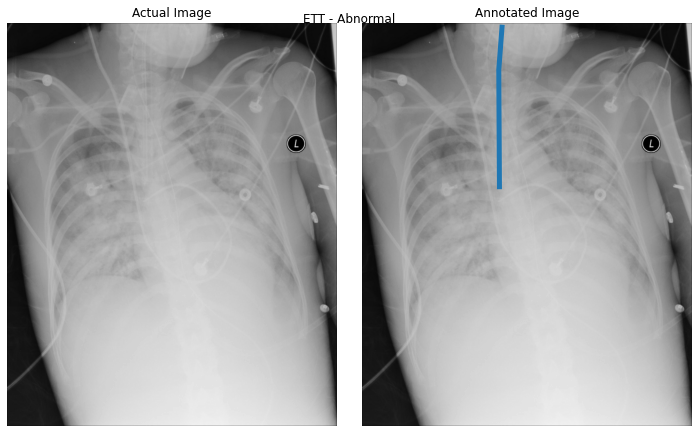

In [13]:
plot_image_and_annotations(imageIds[categories[0]][0], categories[0])

Image dimensions:  (2048, 2500)
Maximum pixel value : 255.0 ; Minimum pixel value:0.0
Mean value of the pixels : 108.9 ; Standard deviation : 53.0


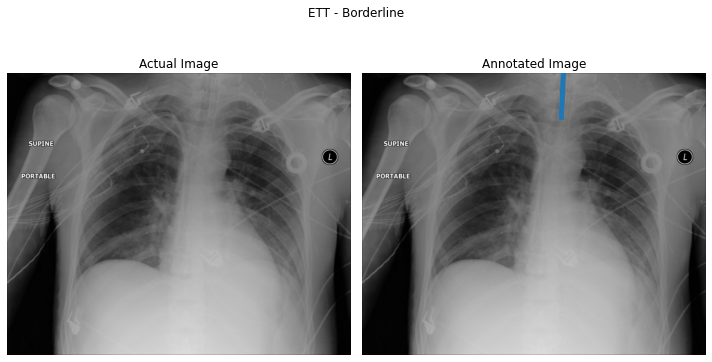

In [14]:
plot_image_and_annotations(imageIds[categories[1]][2], categories[1])

Image dimensions:  (2544, 3056)
Maximum pixel value : 255.0 ; Minimum pixel value:0.0
Mean value of the pixels : 120.5 ; Standard deviation : 72.2


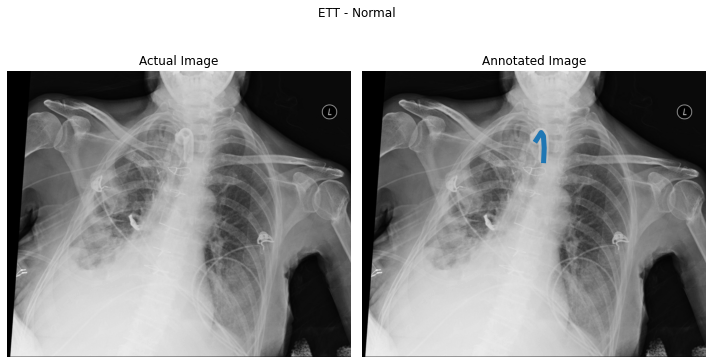

In [15]:
plot_image_and_annotations(imageIds[categories[2]][-1], categories[2])

Image dimensions:  (2048, 2500)
Maximum pixel value : 255.0 ; Minimum pixel value:0.0
Mean value of the pixels : 113.0 ; Standard deviation : 55.6


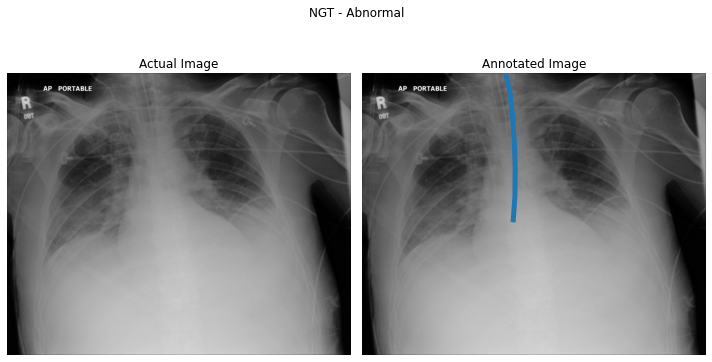

In [16]:
plot_image_and_annotations(imageIds[categories[3]][-1], categories[3])

Image dimensions:  (2991, 2992)
Maximum pixel value : 250.0 ; Minimum pixel value:0.0
Mean value of the pixels : 133.5 ; Standard deviation : 65.5


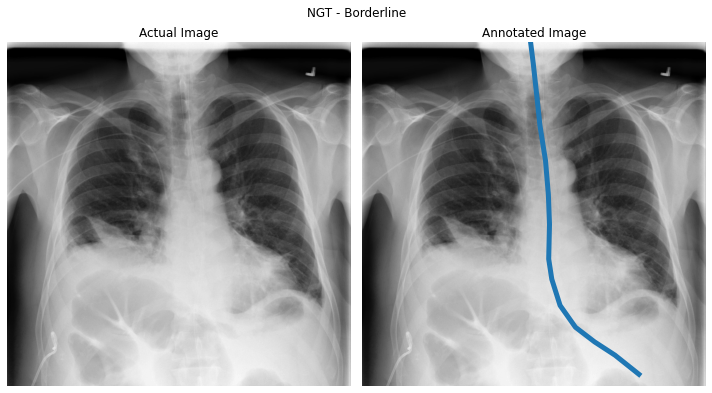

In [17]:
plot_image_and_annotations(imageIds[categories[4]][-1], categories[4])

Image dimensions:  (2544, 3056)
Maximum pixel value : 255.0 ; Minimum pixel value:0.0
Mean value of the pixels : 116.3 ; Standard deviation : 67.4


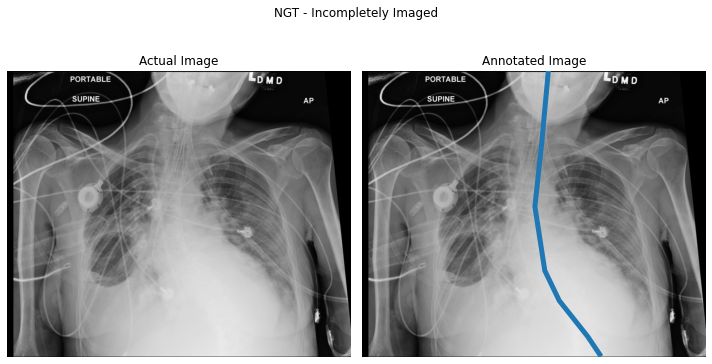

In [18]:
plot_image_and_annotations(imageIds[categories[5]][-1], categories[5])

Image dimensions:  (2544, 3056)
Maximum pixel value : 255.0 ; Minimum pixel value:0.0
Mean value of the pixels : 121.7 ; Standard deviation : 60.4


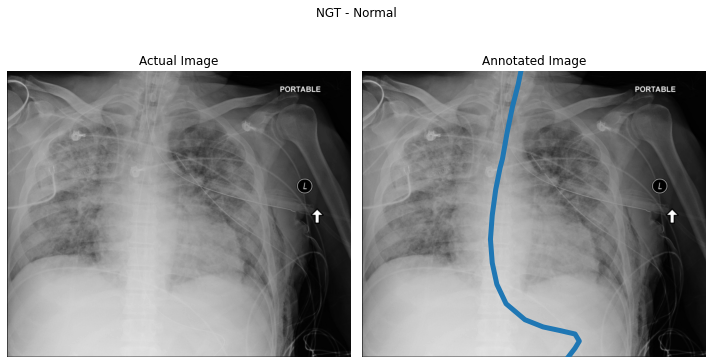

In [19]:
plot_image_and_annotations(imageIds[categories[6]][7], categories[6])

Image dimensions:  (2544, 3056)
Maximum pixel value : 255.0 ; Minimum pixel value:0.0
Mean value of the pixels : 116.3 ; Standard deviation : 67.4


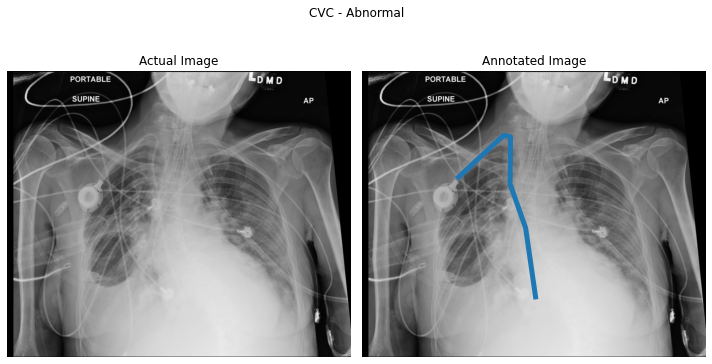

In [20]:
plot_image_and_annotations(imageIds[categories[7]][-1], categories[7])

Image dimensions:  (2493, 2526)
Maximum pixel value : 255.0 ; Minimum pixel value:0.0
Mean value of the pixels : 128.7 ; Standard deviation : 67.8


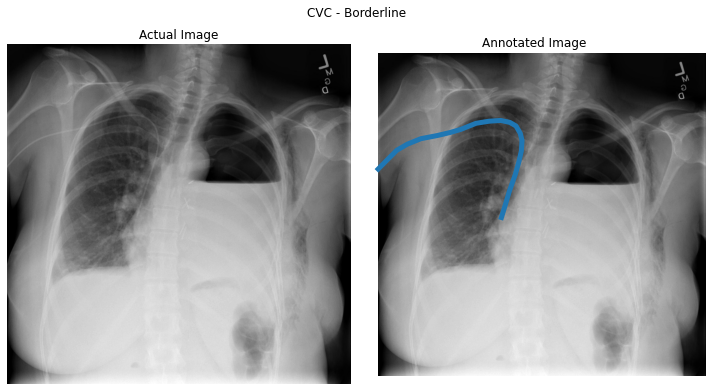

In [21]:
plot_image_and_annotations(imageIds[categories[8]][0], categories[8])

Image dimensions:  (2544, 3056)
Maximum pixel value : 255.0 ; Minimum pixel value:0.0
Mean value of the pixels : 120.5 ; Standard deviation : 72.2


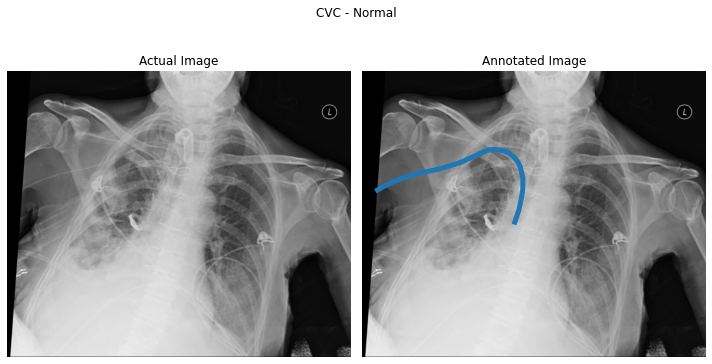

In [22]:
plot_image_and_annotations(imageIds[categories[9]][-1], categories[9])

Image dimensions:  (2048, 2500)
Maximum pixel value : 255.0 ; Minimum pixel value:0.0
Mean value of the pixels : 123.7 ; Standard deviation : 59.8


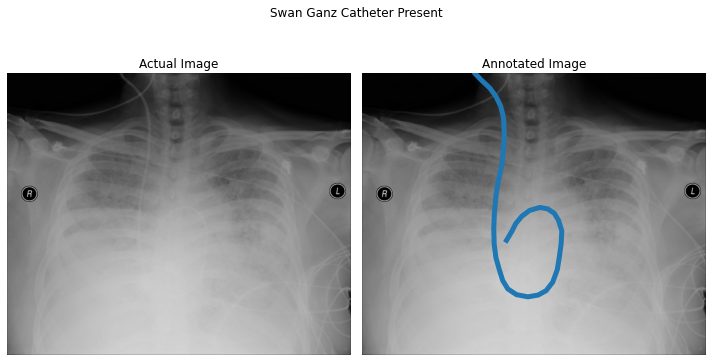

In [23]:
plot_image_and_annotations(imageIds[categories[10]][5], categories[10])

In [24]:
image_width = []
image_height = []
image_channel_mean = []
for image_uid in tqdm(df['StudyInstanceUID'].to_list()):
    image_path = IMAGE_DIR_TRAIN + image_uid + '.jpg'
    img = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
    image_height.append(img.shape[0])
    image_width.append(img.shape[1])
    image_channel_mean.append(np.mean(img))
df['Image Height'] = image_height
df['Image Width'] = image_width
df['Total Pixels'] = df['Image Height'] * df['Image Width']

100%|██████████| 30083/30083 [19:08<00:00, 26.18it/s]


In [25]:
test_image_width = []
test_image_height = []
test_channel_mean = []
for image_name in tqdm(os.listdir(IMAGE_DIR_TEST)):
    image_path = IMAGE_DIR_TEST + image_name
    img = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
    test_image_height.append(img.shape[0])
    test_image_width.append(img.shape[1])
    test_channel_mean.append(np.mean(img))

100%|██████████| 3582/3582 [02:14<00:00, 26.60it/s]


In [26]:
trace0 = go.Violin(x = image_height, name = 'Train Height')
trace1 = go.Violin(x = image_width, name = 'Train Width')

trace2 = go.Violin(x = test_image_width, name = 'Test Width')
trace3 = go.Violin(x = test_image_height, name = 'Test Height')

fig = go.Figure([trace0,trace3, trace1, trace2])
fig.update_layout(title = 'Image Height and Widths', template = 'ggplot2')
fig.show()

In [27]:
fig = ff.create_distplot([image_channel_mean, test_channel_mean], group_labels=['Training Images', 'Testing Images'], colors = ['#cecece','#808080'])
fig.update_layout(template = 'plotly_white', title_text = 'Channel Distribution')
fig.show()

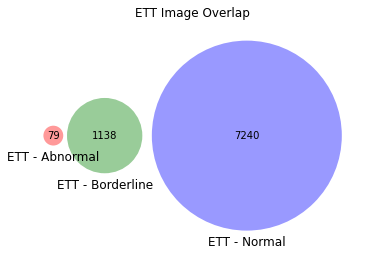

In [28]:
plt.figure(figsize=(6,6))
fig = venn3([set(df[df[col] == 1]['StudyInstanceUID']) for col in ['ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal']], set_labels = ['ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal'])
plt.title('ETT Image Overlap')
plt.show()

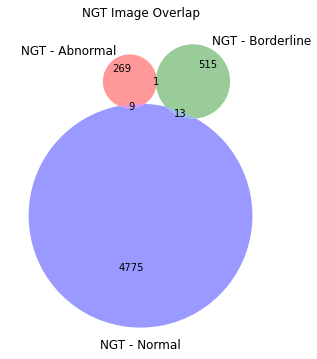

In [29]:
plt.figure(figsize=(6,6))
fig = venn3([set(df[df[col] == 1]['StudyInstanceUID']) for col in ['NGT - Abnormal', 'NGT - Borderline','NGT - Normal']], set_labels = ['NGT - Abnormal', 'NGT - Borderline','NGT - Normal'])
plt.title('NGT Image Overlap')
plt.show()

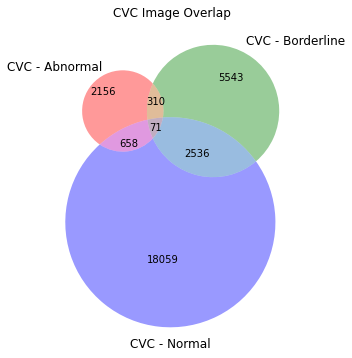

In [30]:
plt.figure(figsize=(6,6))
fig = venn3([set(df[df[col] == 1]['StudyInstanceUID']) for col in ['CVC - Abnormal', 'CVC - Borderline','CVC - Normal']], set_labels = ['CVC - Abnormal', 'CVC - Borderline','CVC - Normal'])
plt.title('CVC Image Overlap')
plt.show()

In [31]:
df[(df['CVC - Abnormal'] == 1) & (df['CVC - Normal'] == 1) & (df['CVC - Borderline'] == 1)]

StudyInstanceUID  ETT - Abnormal  \
182    1.2.826.0.1.3680043.8.498.30375942591308414021...               0   
188    1.2.826.0.1.3680043.8.498.74579763900891627023...               0   
649    1.2.826.0.1.3680043.8.498.92806175825736916132...               0   
1307   1.2.826.0.1.3680043.8.498.11825859042441117993...               0   
1524   1.2.826.0.1.3680043.8.498.19597658072691561369...               0   
...                                                  ...             ...   
27504  1.2.826.0.1.3680043.8.498.30319578732798051425...               0   
28738  1.2.826.0.1.3680043.8.498.14019083825967178262...               0   
29332  1.2.826.0.1.3680043.8.498.11576920990467517205...               0   
29502  1.2.826.0.1.3680043.8.498.54719504364820706916...               0   
29561  1.2.826.0.1.3680043.8.498.10323456350991896825...               0   

       ETT - Borderline  ETT - Normal  NGT - Abnormal  NGT - Borderline  \
182                   1             0               0                 0   
188                   0             0               0                 0   
649                   1             0               0                 0   
1307                  0             1               0                 0   
1524                  0             0               0                 0   
...                 ...           ...             ...               ...   
27504                 0             1               0                 0   
28738                 0             1               0                 0   
29332                 0             1               0                 0   
29502                 0             1               0                 0   
29561                 0             0               0                 0   

       NGT - Incompletely Imaged  NGT - Normal  CVC - Abnormal  \
182                            1             0               1   
188                            0             0               1   
649                            1             0               1   
1307                           0             0               1   
1524                           0             0               1   
...                          ...           ...             ...   
27504                          1             0               1   
28738                          1             0               1   
29332                          1             0               1   
29502                          0             1               1   
29561                          0             0               1   

       CVC - Borderline  CVC - Normal  Swan Ganz Catheter Present  PatientID  \
182                   1             1                           0  ab02c52b6   
188                   1             1                           0  9831bde96   
649                   1             1                           0  26f8065e6   
1307                  1             1                           0  fbea83fd5   
1524                  1             1                           0  5733c2458   
...                 ...           ...                         ...        ...   
27504                 1             1                           0  ab02c52b6   
28738                 1             1                           0  5733c2458   
29332                 1             1                           0  81a4f1598   
29502                 1             1                           0  9aa30fd23   
29561                 1             1                           0  81a4f1598   

       Image Height  Image Width  Total Pixels  
182            2048         2500       5120000  
188            2544         3056       7774464  
649            2048         2500       5120000  
1307           2048         2500       5120000  
1524           2544         3056       7774464  
...             ...          ...           ...  
27504          2048         2500       5120000  
28738          2544         3056       7774464  
29332          2048         250

Image dimensions:  (2544, 3056)
Maximum pixel value : 255.0 ; Minimum pixel value:0.0
Mean value of the pixels : 124.3 ; Standard deviation : 50.9


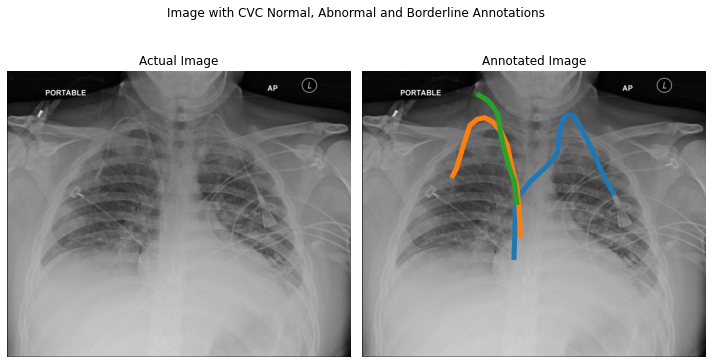

In [32]:
plot_image_and_annotations('1.2.826.0.1.3680043.8.498.74579763900891627023142390145044977755', 'Image with CVC Normal, Abnormal and Borderline Annotations',singleLabel=False)